In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [3]:
!pip install -U umap-learn
import umap

Requirement already up-to-date: umap-learn in /usr/local/lib/python3.6/dist-packages (0.5.0)


In [28]:
def generate_words(cluster_cnts):
    
    prefix = 'W_'
    return [prefix+str(val) for val in range(1, cluster_cnts+1)]

In [29]:
def generate_cluster_words(seq_clusters, cluster_words):
    
    # _assign word to each cluster of the subsequence usnig numpy where function
    assigned_words = np.where(seq_clusters != 0, seq_clusters, cluster_words[0])
    for idx in range(1, len(cluster_words)):
         assigned_words = np.where(seq_clusters != idx, assigned_words, cluster_words[idx])
            
    return assigned_words

In [4]:
plt.rcParams["figure.figsize"] = [16,9]

In [6]:
main_df = pd.read_csv('sensor_features_lstm_tuned.csv', header=None)
print(main_df)

         0         1         2   ...        58        59        60
0       1.0 -0.587281  0.080840  ...  0.875600 -0.713049 -0.901338
1       1.0 -0.599231  0.085383  ...  0.879463 -0.717051 -0.901247
2       1.0 -0.599304  0.085088  ...  0.879690 -0.717256 -0.901344
3       1.0 -0.599482  0.085825  ...  0.879064 -0.716473 -0.901102
4       1.0 -0.598702  0.086125  ...  0.878156 -0.715755 -0.900927
...     ...       ...       ...  ...       ...       ...       ...
11768  17.0 -0.125139  0.138356  ...  0.154357  0.170380 -0.740727
11769  17.0 -0.191166  0.242036  ...  0.105141  0.076240 -0.694695
11770  17.0 -0.072179  0.527310  ...  0.135006 -0.056794 -0.656743
11771  17.0 -0.225445  0.285405  ...  0.181509  0.008481 -0.726518
11772  17.0 -0.176922  0.091612  ...  0.021946  0.179409 -0.658383

[11773 rows x 61 columns]


In [7]:
main_df.iloc[:,1:] = StandardScaler().fit_transform(main_df.iloc[:,1:].to_numpy())

In [8]:
activity_data = main_df.iloc[:, 0].values.astype('int32')
activity_data.shape

(11773,)

In [9]:
sensor_data = main_df.iloc[:,1:].values.astype('float32')
sensor_data.shape

(11773, 60)

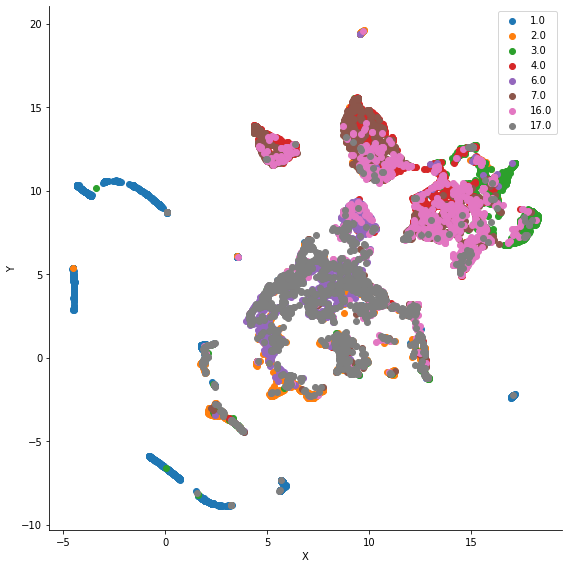

cluster count: 10, sc: 0.4427531957626343
cluster count: 20, sc: 0.48738083243370056
cluster count: 30, sc: 0.5211604833602905
cluster count: 40, sc: 0.48943081498146057
cluster count: 50, sc: 0.45063236355781555
cluster count: 60, sc: 0.4789254367351532
cluster count: 70, sc: 0.4573497772216797
cluster count: 80, sc: 0.44912150502204895
cluster count: 90, sc: 0.4438292682170868
cluster count: 100, sc: 0.4326580762863159


In [67]:
model = umap.UMAP(n_neighbors = 20, min_dist = 0.01, n_components = 2, verbose = False, random_state=23)
tsne_data = model.fit_transform(sensor_data)
final_data = np.append(activity_data.reshape(-1, 1), tsne_data, axis=1)
final_data.shape

# _2D plotting
tsne_df = pd.DataFrame(final_data, columns=['activity_id', 'X', 'Y'])
sn.FacetGrid(tsne_df, hue='activity_id', height=8).map(plt.scatter, 'X', 'Y')
plt.legend(loc="upper right")
plt.show()

tsne_df.iloc[:,1:] = StandardScaler().fit_transform(tsne_df.iloc[:,1:].to_numpy())
tsne_data = tsne_df.iloc[:,1:].values.astype('float32')

for val in range(10, 101, 10):
  gmm = GaussianMixture(n_components=val, random_state=2).fit(tsne_data)
  cluster = gmm.predict(tsne_data)
  sc = silhouette_score(tsne_data, cluster)
  print(f'cluster count: {val}, sc: {sc}')

In [68]:
cluster_cnts=60
gmm = GaussianMixture(n_components=cluster_cnts, random_state=2).fit(tsne_data)
clusters = gmm.predict(tsne_data)
embeddings = gmm.means_
sc = silhouette_score(tsne_data, clusters)
print(sc)

0.47892544


In [69]:
cluster_names = generate_words(cluster_cnts)

doc_df = pd.DataFrame(columns=['activity_label', 'element_name'])
doc_df['activity_label'] = list(activity_data)
doc_df['element_name'] = generate_cluster_words(clusters, cluster_names)
doc_df

,activity_label,element_name
0,1,W_17
1,1,W_17
2,1,W_17
3,1,W_17
4,1,W_17
...,...,...
11768,17,W_20
11769,17,W_20
11770,17,W_27
11771,17,W_20


In [70]:
embeddings_filepath = f'clusters_gmm/word_embeddings_from_clusters.txt'
pd.DataFrame(embeddings).to_csv(embeddings_filepath, index=False, header= False)

In [71]:
for activity in doc_df['activity_label'].unique():
    output_filepath = f'clusters_gmm/activity_subseq_' + str(activity) + '.txt'
    doc_df.loc[doc_df['activity_label'] == activity][['element_name']].to_csv(output_filepath, sep='\t', index=False, header= False)